In [2]:
import numpy as np
import matplotlib.pyplot as plt
import array

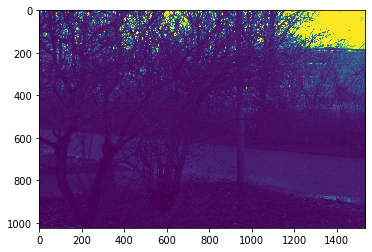

In [4]:
#Try to load up a picture
fn = '00002'
filename='iml_Images\imk'+ fn+ '.iml'
s = open(filename, 'rb').read()
arr = array.array('H', s)
arr.byteswap()
img = np.array(arr, dtype='uint16').reshape(1024, 1536)
plt.imshow(img)


In [39]:
def Dnorm(X):
    '''
    Compute the D-norm of matrix X
    '''
    #Matrix D for computing D-norm
    D = np.array([
        [2, -1, 0, -1, 0, 0, 0, 0, 0],
        [-1, 3, -1, 0, -1, 0, 0, 0, 0],
        [0, -1, 2, 0, 0, -1, 0, 0, 0],
        [-1, 0, 0, 3, -1, 0, -1, 0, 0],
        [0, -1, 0, -1, 4, -1, 0, -1, 0],
        [0, 0, -1, 0, -1, 3, 0, 0, -1],
        [0, 0, 0, -1, 0, 0, 2, -1, 0],
        [0, 0, 0, 0, -1, 0, -1, 3, -1],
        [0, 0, 0, 0, 0, -1, 0, -1, 2]])
    #sqrt(X^T D X)
    Dn = np.sqrt((X.dot(D)*X).sum(axis=1))
    return Dn

def DCT_Transform(b):
    '''
    Transform a vector x in the standard basis into the DCT basis
    '''
    #2-dimensional Discrete Cosine Transform (DCT) basis of a 3×3 image patch diagonalizes the matrix D
    sqrt6 = np.sqrt(6)
    sqrt54 = np.sqrt(54)
    sqrt8 = np.sqrt(8)
    sqrt48 = np.sqrt(48)
    sqrt216 = np.sqrt(216)
    #DCT is 8x9
    DCT = np.array([
        [1/sqrt6, 0, -1/sqrt6, 1/sqrt6, 0, -1/sqrt6, 1/sqrt6, 0, -1/sqrt6 ],
        [1/sqrt6, 1/sqrt6, 1/sqrt6, 0, 0, 0, -1/sqrt6, -1/sqrt6, -1/sqrt6 ],
        [1/sqrt54, -2/sqrt54, 1/sqrt54, 1/sqrt54, -2/sqrt54, 1/sqrt54, 1/sqrt54, -2/sqrt54, 1/sqrt54],
        [1/sqrt54, 1/sqrt54, 1/sqrt54, -2/sqrt54, -2/sqrt54, -2/sqrt54, 1/sqrt54, 1/sqrt54, 1/sqrt54],
        [1/sqrt8, 0, -1/sqrt8, 0, 0, 0, -1/sqrt8, 0, 1/sqrt8],
        [1/sqrt48, 0, -1/sqrt48, -2/sqrt48, 0, 2/sqrt48, 1/sqrt48, 0, -1/sqrt48],
        [1/sqrt48, -2/sqrt48, 1, 0, 0, 0, -1/sqrt48, 2/sqrt48, -1/sqrt48],
        [1/sqrt216, -2/sqrt216, 1/sqrt216, -2/sqrt216, 4/sqrt216, -2/sqrt216, 1/sqrt216, -2/sqrt216, 1/sqrt216]
    ])
    Lambda = np.diag(np.linalg.norm(DCT, ord=2, axis=1)**2)
    #linear transformation
    x = np.dot(np.matmul(Lambda, DCT), b)
    return x

In [26]:
def fnameFix(fn):
    '''
    The numbers in the files are 5 digits.
    Add 0 in front until we have 5 digits.
    '''
    while(len(fn) < 5):
        fn = '0'+ fn
    return fn


In [45]:
def PatExt(fn):
    '''
    Perform patch selections for a single images as detailed in carlsson
    '''
    #dimension of the images
    nrow=1024
    ncol=1536
    #Load the image
    fn = fnameFix(fn)
    filename='iml_Images\imk'+ fn + '.iml'
    s = open(filename, 'rb').read()
    arr = array.array('H', s)
    arr.byteswap()
    img = np.array(arr, dtype='uint16').reshape(nrow, ncol)
    
    #extract 5000 random 3x3 pathches.
    #Note The two leftmost and the two rightmost pixel columns do not contain information
    
    #iniate a matrix to store 5000 flattened 3x3 pathes (5000 samples with 9 features/coordinates)
    Patches = np.zeros((5000,9))
    #the rows and columns we can select from
    rows = np.arange(1, nrow-1)
    cols = np.arange(3, ncol-3)
    for i in range(5000):
        #select a random center
        x = np.random.choice(rows)
        y = np.random.choice(cols)
        #stored the flattened patches
        Patches[i,] = img[x-1:x+2, y-1:y+2].flatten()
    #Compute the logarithm of intensity at each pixel.
    Patches = np.log(Patches)
    #Subtract an average of all coordinates from each coordinate.
    colMeans = np.mean(Patches, axis=0)
    Patches = Patches-colMeans
    #compute D-norms for each vector and record the top 1000 D-norms
    Dns = Dnorm(Patches)
    hC_Indices = np.argsort(Dns)[0:1000,]
    #Store the normalized and DCT-transformed high contrast patches
    hC_DCT_Patches = np.zeros((1000,8)) #7-dimensional sphere in R8
    for i in range(1000):
        im_ind = hC_Indices[i] #index of the i-th high contrast patches 
        hC_DCT_Patches[i] = DCT_Transform(Patches[im_ind,]/Dns[im_ind]) #DCT transform the normalized patches
    
    return hC_DCT_Patches

def PatchesExtractions(numImages = 5):
    '''
    Perform patch selections for multiple images
    '''
    #Select numImages amount Images from 4212 images
    img_indices = np.random.choice(np.arange(1, 4213), size=numImages, replace=False)
    Patches = np.zeros((numImages, 1000, 8))
    for i in range(numImages):
        fn = str(img_indices[i])
        Patches[i] = PatExt(fn)
    print(img_indices)
    np.save('3x3Patches', Patches)
    return



In [46]:
PatchesExtractions(numImages = 5)

[1111 3850 1698 2619 3002]
